<a href="https://colab.research.google.com/github/DexterDSilva/face-mask-detector/blob/master/train_face_mask_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

FACE MASK DETECTOR IN 
[GITHUB](https://github.com/DexterDSilva/face-mask-detector/tree/master)

#ACCESS DATA
https://github.com/DexterDSilva/face-mask-detector/tree/master/dataset/with-mask

https://github.com/DexterDSilva/face-mask-detector/tree/master/dataset/without_mask



In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
root_dir='/content/drive/My Drive/Colab Notebooks/pyimage-covid19'

In [0]:
import os
os.chdir(root_dir)

In [6]:
!git clone https://github.com/DexterDSilva/face-mask-detector.git

fatal: destination path 'face-mask-detector' already exists and is not an empty directory.


In [4]:
proj_dir = os.path.join(root_dir, 'face-mask-detector');proj_dir

'/content/drive/My Drive/Colab Notebooks/pyimage-covid19/face-mask-detector'

In [5]:
os.listdir(proj_dir)

['.git',
 'COVID-19: Face Mask Detector with OpenCV, Keras:TensorFlow, and Deep Learning - PyImageSearch.pdf',
 'COVID-19_ Face Mask Detector with OpenCV, Keras_TensorFlow, and Deep Learning - PyImageSearch.pdf',
 'dataset',
 'detect_mask_image.py',
 'detect_mask_video.py',
 'examples',
 'face-mask-detector.ipynb',
 'face_detector',
 'generate-mask-images',
 'mask_detector.model',
 'plot.png',
 'readme.txt',
 'train_mask_detector.py']

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np

In [0]:
INIT_LR = 1e-4
EPOCHS = 20
BS =32

In [9]:
dataset = os.path.join(proj_dir,'dataset')
image_paths = list(paths.list_images(dataset))
data=[]
labels=[]
print(len(image_paths))
testpath = image_paths[3]
print(testpath.split(os.path.sep))
op = testpath.split(os.path.sep)[-2];op

1376
['', 'content', 'drive', 'My Drive', 'Colab Notebooks', 'pyimage-covid19', 'face-mask-detector', 'dataset', 'with_mask', '100-with-mask.jpg']


'with_mask'

In [0]:
for image_path in image_paths:
  label=image_path.split(os.path.sep)[-2]

  image = load_img(image_path, target_size=(224,224))
  image = img_to_array(image)
  image = preprocess_input(image)

  data.append(image)
  labels.append(label)

In [0]:
data = np.array(data, dtype='float32')
labels=np.array(labels)

In [12]:
test_image = image_paths[100];test_image

'/content/drive/My Drive/Colab Notebooks/pyimage-covid19/face-mask-detector/dataset/with_mask/198-with-mask.jpg'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


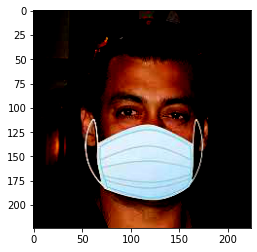

In [13]:
plt.imshow(data[100])

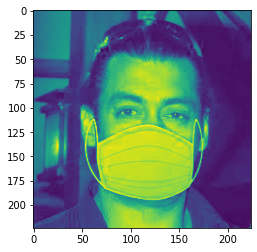

In [14]:
lum_img = data[100][:,:,0]
plt.imshow(lum_img)

In [0]:
from PIL import Image
img1 = Image.open(image_paths[100])
img1.show()

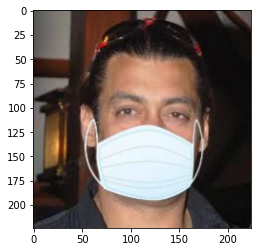

In [16]:
import cv2
im = cv2.imread(image_paths[100])
im_resized = cv2.resize(im, (224, 224), interpolation=cv2.INTER_LINEAR)
plt.imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB))
plt.show()

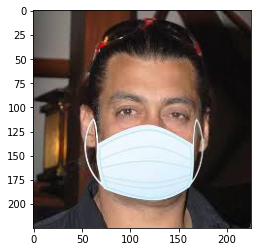

In [17]:
import matplotlib.image as mpimg
img2 = mpimg.imread(test_image)
plt.imshow(img2)

In [0]:
#one hot encoding on labels
lb = LabelBinarizer()
labels=lb.fit_transform(labels)
labels = to_categorical(labels)

In [19]:
labels[100]

array([1., 0.], dtype=float32)

In [0]:
(trainX, testX, trainY, testY) =train_test_split(data,labels,
                                                 test_size=0.2,
                                                 stratify=labels,
                                                 random_state=42)

In [33]:
print(trainX.shape, trainY.shape, testX.shape,testY.shape)

(1100, 224, 224, 3) (1100, 2) (276, 224, 224, 3) (276, 2)


In [0]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [0]:
base_model=()

In [23]:
base_model = MobileNetV2(weights='imagenet',
                         include_top=False,
                         input_tensor=Input(shape=(224,224,3)))

9412608/9406464 [==============================] - 0s 0us/step


In [25]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [0]:
head_model = base_model.output
head_model = AveragePooling2D(pool_size=(7,7))(head_model)
head_model = Flatten(name='Flatten')(head_model)
head_model = Dense(128, activation='relu')(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(2, activation = 'softmax')(head_model)

In [0]:
model = Model(inputs=base_model.input, outputs=head_model)

for layer in base_model.layers:
  layer.trainable=False

In [0]:
opt = Adam(lr=INIT_LR, decay=INIT_LR/EPOCHS)

model.compile(loss='binary_crossentropy', optimizer=opt,
              metrics=['accuracy'])

In [29]:
h = model.fit(
    aug.flow(trainX,trainY,batch_size=BS),
    steps_per_epoch=len(trainX)//BS,
    validation_data=(testX, testY),
    validation_steps=len(testX)//BS,
    epochs=EPOCHS
    )

Epoch 1/20
34/34 [==============================] - 13s 369ms/step - loss: 0.3990 - accuracy: 0.8235 - val_loss: 0.1289 - val_accuracy: 0.9565
Epoch 2/20
34/34 [==============================] - 11s 331ms/step - loss: 0.1233 - accuracy: 0.9588 - val_loss: 0.0621 - val_accuracy: 0.9819
Epoch 3/20
34/34 [==============================] - 11s 326ms/step - loss: 0.0594 - accuracy: 0.9860 - val_loss: 0.0409 - val_accuracy: 0.9891
Epoch 4/20
34/34 [==============================] - 11s 328ms/step - loss: 0.0457 - accuracy: 0.9860 - val_loss: 0.0300 - val_accuracy: 0.9964
Epoch 5/20
34/34 [==============================] - 11s 325ms/step - loss: 0.0392 - accuracy: 0.9860 - val_loss: 0.0257 - val_accuracy: 0.9964
Epoch 6/20
34/34 [==============================] - 11s 320ms/step - loss: 0.0259 - accuracy: 0.9963 - val_loss: 0.0266 - val_accuracy: 0.9891
Epoch 7/20
34/34 [==============================] - 11s 323ms/step - loss: 0.0331 - accuracy: 0.9888 - val_loss: 0.0190 - val_accuracy: 1.0000

In [0]:
pred_idxs = model.predict(testX, batch_size=BS)

In [32]:
type(pred_idxs)
pred_idxs.shape

(276, 2)

In [34]:
print(pred_idxs[0])

[0.5475899 0.4524101]


In [0]:
pred_idxs = np.argmax(pred_idxs,axis=1)

In [36]:
print(classification_report(testY.argmax(axis=1),pred_idxs,
                            target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00       138
without_mask       1.00      1.00      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276



In [0]:
#model.save(os.path.join(proj_dir, 'trained_model.h5'),save_format='h5)
model.save(os.path.join(proj_dir, 'trained_model.h5'))

In [38]:
os.listdir(proj_dir)

['.git',
 'COVID-19: Face Mask Detector with OpenCV, Keras:TensorFlow, and Deep Learning - PyImageSearch.pdf',
 'COVID-19_ Face Mask Detector with OpenCV, Keras_TensorFlow, and Deep Learning - PyImageSearch.pdf',
 'dataset',
 'detect_mask_image.py',
 'detect_mask_video.py',
 'examples',
 'face-mask-detector.ipynb',
 'face_detector',
 'generate-mask-images',
 'mask_detector.model',
 'plot.png',
 'readme.txt',
 'train_mask_detector.py',
 'trained_model.h5']

In [40]:
h.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

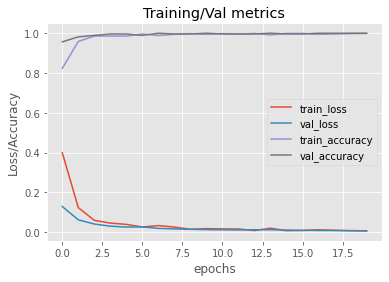

In [45]:
N=EPOCHS
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0,N),h.history['loss'], label='train_loss')
plt.plot(np.arange(0,N), h.history['val_loss'], label= 'val_loss')
plt.plot(np.arange(0,N), h.history['accuracy'], label='train_accuracy')
plt.plot(np.arange(0,N), h.history['val_accuracy'], label='val_accuracy')
plt.title('Training/Val metrics')
plt.xlabel('epochs')
plt.ylabel('Loss/Accuracy')
plt.legend(loc='center right')
plt.savefig(os.path.join(proj_dir,'metrics.png'))


In [46]:
os.listdir(proj_dir)

['.git',
 'COVID-19: Face Mask Detector with OpenCV, Keras:TensorFlow, and Deep Learning - PyImageSearch.pdf',
 'COVID-19_ Face Mask Detector with OpenCV, Keras_TensorFlow, and Deep Learning - PyImageSearch.pdf',
 'dataset',
 'detect_mask_image.py',
 'detect_mask_video.py',
 'examples',
 'face-mask-detector.ipynb',
 'face_detector',
 'generate-mask-images',
 'mask_detector.model',
 'plot.png',
 'readme.txt',
 'train_mask_detector.py',
 'trained_model.h5',
 'metrics.png']